In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM



In [24]:
# Fetch historical stock data for a particular company
ticker = "^NSEI"
data = yf.download(ticker, start="2015-01-01", end="2022-01-01")



[*********************100%***********************]  1 of 1 completed


In [25]:
# Preprocess the data
data = data[['Close']]
data = data.dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)



In [26]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]



In [27]:
# Define the function to create the dataset with a look back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



In [28]:
# Create the dataset with a look back
look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)



In [29]:
# Reshape the input data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [30]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



In [31]:
# Train the LSTM model
model.fit(X_train, Y_train, epochs=100, batch_size=32)



Epoch 1/100
42/42 [==============================] - 14s 191ms/step - loss: 0.0102
Epoch 2/100
42/42 [==============================] - 7s 170ms/step - loss: 7.4881e-04
Epoch 3/100
42/42 [==============================] - 7s 158ms/step - loss: 4.4030e-04
Epoch 4/100
42/42 [==============================] - 6s 150ms/step - loss: 4.0994e-04
Epoch 5/100
42/42 [==============================] - 6s 137ms/step - loss: 4.0354e-04
Epoch 6/100
42/42 [==============================] - 6s 144ms/step - loss: 3.6126e-04
Epoch 7/100
42/42 [==============================] - 6s 140ms/step - loss: 3.3672e-04
Epoch 8/100
42/42 [==============================] - 6s 148ms/step - loss: 3.1107e-04
Epoch 9/100
42/42 [==============================] - 6s 138ms/step - loss: 2.9617e-04
Epoch 10/100
42/42 [==============================] - 6s 145ms/step - loss: 2.9791e-04
Epoch 11/100
42/42 [==============================] - 6s 139ms/step - loss: 2.7823e-04
Epoch 12/100
42/42 [==============================] - 6

In [36]:
# Make predictions on the testing data
pred = model.predict(X_test)
pred = pd.DataFrame(data=pred)
pred


9/9 [==============================] - 1s 58ms/step


,0
0,0.459385
1,0.476483
2,0.492684
3,0.505151
4,0.505253
...,...
278,0.802348
279,0.805161
280,0.810087
281,0.819037


In [ ]:
# # Inverse the scaling to get the actual stock prices
pred = scaler.inverse_transform(pred)
Y_test = scaler.inverse_transform([Y_test])
pred




In [65]:
# Calculate evaluation metrics such as mean squared error (MSE) and root mean squared error (RMSE)
MSE = mean_squared_error(Y_test[0], pred[:,0])
RMSE = np.sqrt(MSE)
print("MSE: ", MSE)
print("RMSE: ", RMSE)



MSE:  1.2592593613071124e+57
RMSE:  3.5486044599350775e+28


In [42]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test,pred)
r2

0.8731411552229136

<AxesSubplot: xlabel='Date'>

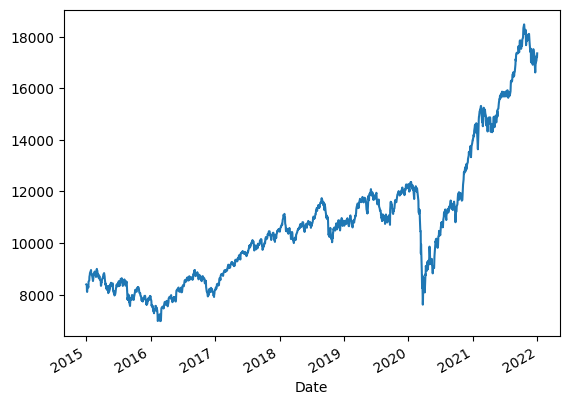

In [41]:
data['Close'].plot()

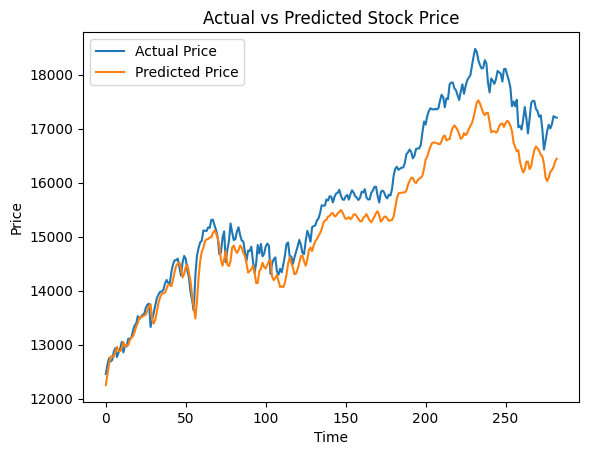

In [58]:
import matplotlib.pyplot as plt

# Plot the actual and predicted stock prices
plt.plot(Y_test[0], label='Actual Price')
plt.plot(pred[:,0], label='Predicted Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
